In [1]:
"""
Pre-processing PlanetScope SuperDove imagery

1. Calculate Spectral Indices:
    a. Normalized Difference Red-edge Index (NDRE)
    b. Visible Green-Based Built-Up Index (VgNIRBI)
    c. Visible Red-Based Built-Up Index (VrNIRBI)
    d. Blue-Green Normalized Built-Up Index (NDBIbg)
    e. Red-Green Normalized Built-up Index (NDBIrg)
    f. Normalized Impervious Surface Index (NISI)

2. Check Band Correlations

3. Minimum Noise Fraction (MNF) Transformation

4. Remove Highly Correlated Bands

5. Texture Calculations

5. Export to GeoTIFF

"""


import os, sys, time
from glob import glob
import rioxarray as rxr
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import earthpy.plot as ep
import rasterio as rio
import pysptools.util as sp_utils
import geopandas as gpd
import warnings
import gc

from rioxarray.merge import merge_arrays
from rasterio.crs import CRS

warnings.filterwarnings('ignore')

begin = time.time()  # start time

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

# Load the environment variables

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'

# Coordinate Ref. System
proj = 32618  # UTM Zone 18N (Washington, D.C.)

print("Ready !")

Ready !


In [2]:
# PSScene list of GeoTIFFs
psscenes = glob(os.path.join(maindir,'data/spatial/raw/dc_data/planet-data/PSScene8Band_23/*_composite.tif'))
# psscenes = glob(os.path.join(maindir,'data/spatial/raw/*/*/*/*_composite.tif'))
print([os.path.basename(f) for f in psscenes])

['2023-06-02_strip_6551610_composite.tif', '2023-06-02_strip_6551575_composite.tif']


In [3]:
# Open the files and store in a list
strips = []
for i in range(len(psscenes)):
    print(os.path.basename(psscenes[i]))
    strip = rxr.open_rasterio(
        psscenes[i],masked=True,cache=False
    ).squeeze().astype(rio.uint16)
    strips.append(strip)  # append to the empty list
    del strip

print(strips[0].rio.crs)
print(strips[0].rio.resolution())
height, width = strips[0].rio.resolution()[0], strips[0].rio.resolution()[1]

2023-06-02_strip_6551610_composite.tif
2023-06-02_strip_6551575_composite.tif
EPSG:32618
(3.0, -3.0)


In [4]:
# Merge the strips
mosaic = merge_arrays(
    dataarrays=strips,
    res=(height, abs(width)),
    crs=CRS.from_epsg(proj),
    nodata=0,
    method='max'
)

# Define the list of long names for each band
long_names = ['coastal_blue', 'blue', 'green_i', 'green', 'yellow', 'red', 'rededge', 'nir']
# Assign long names to each band
mosaic.attrs['long_name'] = tuple(long_names)
# Print raster attributes
shp, gt, wkt, nd = mosaic.shape, mosaic.spatial_ref.GeoTransform, mosaic.rio.crs, mosaic.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Bands: {mosaic.band}; \n"
    f"Band Names: {mosaic.attrs['long_name']}; \n"
    f"Data Type: {mosaic[0].dtype}")

# Write to disk
out_img = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b.tif')
mosaic.rio.to_raster(
    out_img, compress='zstd', zstd_level=9,
    dtype='uint16', driver='GTiff')
strips = []  # clear the list

print(f"Successfully exported the 8-band composite: {out_img}")

del mosaic, strips, height, width   # clean up
gc.collect()

Shape: (8, 8223, 6714); 
GeoTransform: 315267.0 3.0 0.0 4319298.0 0.0 -3.0; 
WKT: EPSG:32618; 
NoData Value: 0; 
Bands: <xarray.DataArray 'band' (band: 8)> Size: 64B
array([1, 2, 3, 4, 5, 6, 7, 8])
Coordinates:
  * band         (band) int64 64B 1 2 3 4 5 6 7 8
    spatial_ref  int64 8B 0; 
Band Names: ('coastal_blue', 'blue', 'green_i', 'green', 'yellow', 'red', 'rededge', 'nir'); 
Data Type: uint16
Successfully exported the 8-band composite: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b.tif


137

In [5]:
# Reload the mosaic
da = rxr.open_rasterio(out_img, masked=True, cache=False)
print(da)

<xarray.DataArray (band: 8, y: 8223, x: 6714)> Size: 2GB
[441673776 values with dtype=float32]
Coordinates:
  * band         (band) int64 64B 1 2 3 4 5 6 7 8
  * x            (x) float64 54kB 3.153e+05 3.153e+05 ... 3.354e+05 3.354e+05
  * y            (y) float64 66kB 4.319e+06 4.319e+06 ... 4.295e+06 4.295e+06
    spatial_ref  int64 8B 0
Attributes:
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        15296
    STATISTICS_MEAN:           610.98447553229
    STATISTICS_MINIMUM:        16
    STATISTICS_STDDEV:         321.59520811687
    STATISTICS_VALID_PERCENT:  91.15
    AREA_OR_POINT:             Area
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 ('coastal_blue', 'blue', 'green_i', 'green', '...


In [6]:
print(da[1])

<xarray.DataArray (y: 8223, x: 6714)> Size: 221MB
[55209222 values with dtype=float32]
Coordinates:
    band         int64 8B 2
  * x            (x) float64 54kB 3.153e+05 3.153e+05 ... 3.354e+05 3.354e+05
  * y            (y) float64 66kB 4.319e+06 4.319e+06 ... 4.295e+06 4.295e+06
    spatial_ref  int64 8B 0
Attributes:
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        15296
    STATISTICS_MEAN:           610.98447553229
    STATISTICS_MINIMUM:        16
    STATISTICS_STDDEV:         321.59520811687
    STATISTICS_VALID_PERCENT:  91.15
    AREA_OR_POINT:             Area
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 ('coastal_blue', 'blue', 'green_i', 'green', '...


In [7]:
# Calculate the spectral indices

# Copy attributes from the Green band (arbitrary, could be any band)
NDRE = da[3].copy(data=(da[7] - da[6]) / (da[7] + da[6])) # red, nir
VgNIRBI = da[3].copy(data=(da[3] - da[7]) / (da[3] + da[7]))  # 'green','nir'
VrNIRBI = da[3].copy(data=(da[5] - da[7]) / (da[5] + da[7]))  # 'red','nir'
NDBIbg = da[3].copy(data=(da[1] - da[3]) / (da[1] + da[3]))  # 'blue','green'
NDBIrg = da[3].copy(data=(da[5] - da[3]) / (da[5] + da[3]))  # 'red','green'
NISI = da[3].copy(data=(((da[1] + da[3] + da[5]) - da[7]) / ((da[1] + da[3] + da[5]) + da[7])))

# Put the indices into a list
si_stack = xr.concat([NDRE, VgNIRBI, VrNIRBI, NDBIbg, NDBIrg, NISI], dim='band')  # create and image stack

# Reorder the band numbers in prep to merge
si_stack = si_stack.assign_coords(band=np.arange(9, 9 + si_stack.shape[0]))

# Define the list of long names for each band
si_long_names = ['NDRE', 'VgNIRBI', 'VrNIRBI', 'NDBIbg', 'NDBIrg', 'NISI']
# Assign long names to each band
si_stack.attrs['long_name'] = tuple(long_names)

# Print the attributes
print_raster(si_stack, open_file=False)

del NDRE, VgNIRBI, VrNIRBI, NDBIbg, NDBIrg, NISI
gc.collect()

shape: (8223, 6714)
resolution: (3.0, -3.0)
bounds: (315267.0, 4294629.0, 335409.0, 4319298.0)
sum: -64148008.0
CRS: EPSG:32618
NoData: nanArray: <xarray.DataArray (band: 6, y: 8223, x: 6714)> Size: 1GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan

0

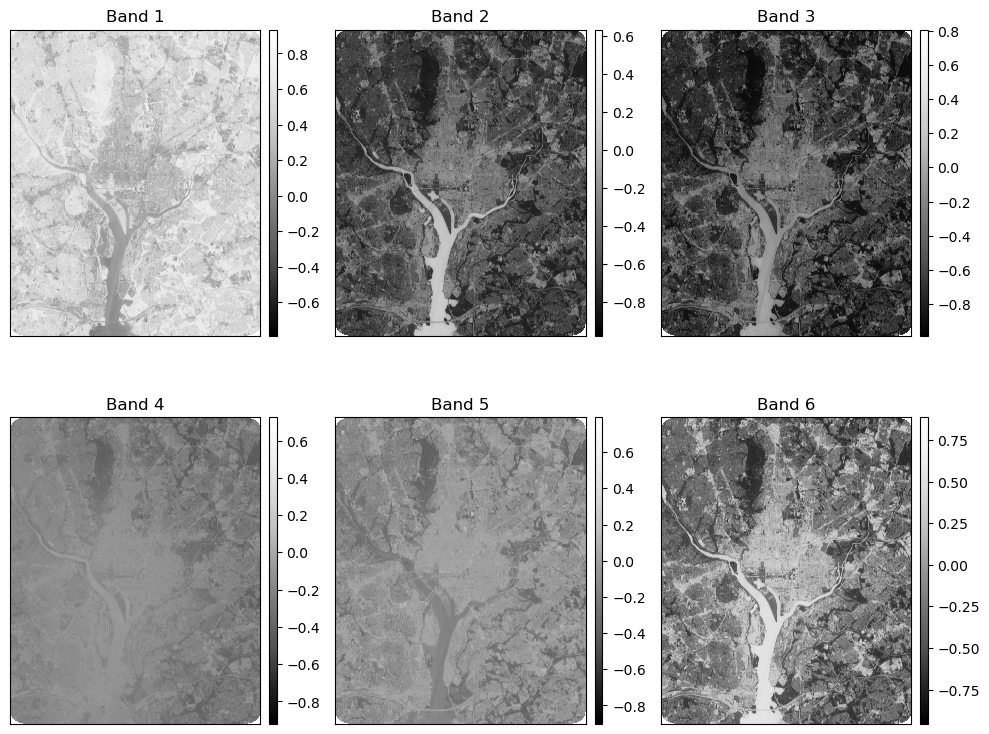

array([[<Axes: title={'center': 'Band 1'}>,
        <Axes: title={'center': 'Band 2'}>,
        <Axes: title={'center': 'Band 3'}>],
       [<Axes: title={'center': 'Band 4'}>,
        <Axes: title={'center': 'Band 5'}>,
        <Axes: title={'center': 'Band 6'}>]], dtype=object)

In [8]:
ep.plot_bands(si_stack, scale=False, figsize=(10,8))

In [9]:
# Stack the original SuperDove bands and the spectral indices

shape: (14, 8223, 6714); long_name: ('coastal_blue', 'blue', 'green_i', 'green', 'yellow', 'red', 'rededge', 'nir', 'NDRE', 'VgNIRBI', 'VrNIRBI', 'NDBIbg', 'NDBIrg', 'NISI')


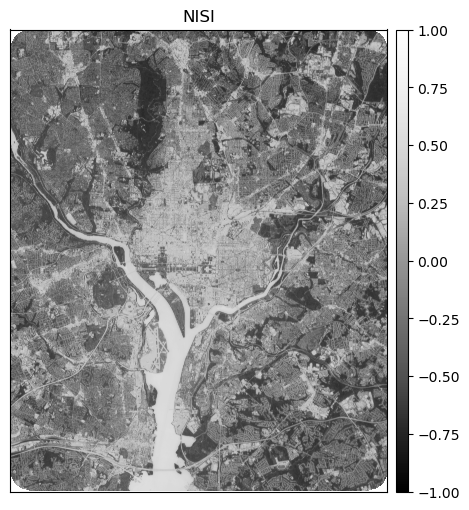

<Axes: title={'center': 'NISI'}>

In [10]:
# Create the final multi-band image stack
da_stack = xr.concat([da, si_stack], dim='band').astype(np.float32)

# Update the long_name attribute to include the other names
long_names = list(da_stack.attrs['long_name']) + si_long_names
da_stack.attrs['long_name'] = tuple(long_names)
print(f"shape: {da_stack.shape}; long_name: {da_stack.attrs['long_name']}")

# Test by plotting the 9th band (should be vgnir)
ep.plot_bands(
    da_stack[13].squeeze(),
    scale=False,
    vmin=-1,vmax=1,
    title="NISI",
    figsize=(6,6))

In [11]:
del da, si_stack
gc.collect()

138

### Examine Band Correlations

In [12]:
# Convert to a numpy array and test band correlations
image_np = da_stack.values

# img_data is now a numpy array of shape (bands, height, width)
print(f"Image data shape: {image_np.shape}")
print(f"Data type: {image_np.dtype}")
# Check if the data contains only zeros or NaNs
print(f"Data contains NaNs: {np.isnan(image_np).any()}")
print(f"Data contains only zeros: {np.all(image_np == 0)}")

Image data shape: (14, 8223, 6714)
Data type: float32
Data contains NaNs: True
Data contains only zeros: False


In [13]:
out_png = os.path.join(maindir,'figures/FigX_band_correlations.png')
band_correlations(da_stack, out_png) # see functions.py
gc.collect()

NameError: name 'band_correlations' is not defined

### Calculate Minimum Noise Fraction (MNF) Transform

The Planet SuperDove visible bands (1-7) are highly correlated (all but the NIR). To handle this issue, we can try to distill the information down using a decomposition method. Minimum Noise Fraction minimizes noise in an image, producing sequential images of decreasing quality.

In [ ]:
print(f"Image array shape: {image_np.shape}; and type: {type(image_np)}")

In [ ]:
planet_bands_vis = image_np[:7, ...]
planet_bands_vis = np.nan_to_num(planet_bands_vis, nan=0.0)
print(planet_bands_vis.shape)

In [ ]:
# MNF transform implmentation
da_mnf = mnf_transform(planet_bands_vis)  # see functions.py
print(
    f"MNF image shape: {da_mnf.shape}; \n"
    f"transposed shape: {da_mnf.T.shape}; \n"
    f"and type: {type(da_mnf)};")

In [ ]:
# Explore the dimensionality of the data
# Filter out NoData values from the MNF-transformed image
filtered = ravel_and_filter(np.where(planet_bands_vis == 0, 0, da_mnf.T))
# Obtain the covariance matrix
cov_m = sp_utils.cov(filtered)
# Compute the eigenvalues, sort them, reverse the sorting
eigenvals = np.sort(np.linalg.eig(cov_m)[0])[::-1]
eigenvals_p = np.power(eigenvals, 2) / sum(np.power(eigenvals, 2))
print(f"Variance explained by MNF rotations: \n {list(map(lambda x: round(x, 3), eigenvals_p.tolist()))}")

In [ ]:
# retain the first rotation which explains 100% (??) of the variation
da_mnf_ = da_mnf[:,:,:1].T # transpose to match the da stack
print(da_mnf_.shape)

del da_mnf
gc.collect()

In [ ]:
# Export to GeoTIFF
out_path = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_mnf.tif')
mnf_img = array_to_tif(da_mnf_.T, da_stack, out_path, 'float32', clip=False)  

# Convert to DataArray
mnf_array = xr.DataArray(data=da_mnf_, # transposed mnf array
                         dims=['band','y', 'x'],
                         coords={'y': da_stack.coords['y'], 'x': da_stack.coords['x'], 'band': [15]},
                         attrs=da_stack.attrs)

# Set the long name for the MNF band
mnf_array.attrs['long_name'] = 'mnf1'
mnf_array.rio.write_crs(proj, inplace=True) # write the CRS
print(mnf_array)

In [ ]:
del da_mnf_, filtered, cov_m, eigenvals, eigenvals_p
gc.collect()

In [ ]:
# Merge into new data stack with correlated SuperDove bands removed
da_stack_ = da_stack[7:, :, :] # drop the superdove bands
stack_out = xr.concat([da_stack_, mnf_array], dim='band') # Concatenate all bands
print(stack_out.shape)

In [ ]:
del da_stack
gc.collect()

In [ ]:
# Update 'long_name' attribute
new_bands = ['nir', 'NDRE', 'VgNIRBI', 'VrNIRBI', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1']
stack_out.attrs['long_name'] = new_bands
print(
    f"Shape: {stack_out.shape}; \n"
    f"CRS:  {stack_out.rio.crs}; \n"
    f"NoData Value: {stack_out.rio.nodata}; \n"
    f"Bands: {stack_out.band}; \n"
    f"Band Names: {stack_out.long_name}; \n"
    f"Data Type: {stack_out[0].dtype}")

In [ ]:
# Plot the final bands (MNF + Indices)
ep.plot_bands(stack_out, figsize=(8,8))

In [ ]:
# RERUN THE CORRELATION

In [ ]:
print(new_bands)

# Plot the correlation matrix
out_png = os.path.join(maindir,'figures/FigX_band_correlations_filtered.png')
band_correlations(stack_out, out_png)

gc.collect()

##### It appears that the NDRE, VgNIRBI, and VrNIRBI are all highly correlated. These bands are also highly correlated with the NISI. So, we should remove the three bands and keep NISI

In [ ]:
# List of long names of the bands to remove
rm_names = ['NDRE', 'VgNIRBI', 'VrNIRBI']
# Get the indices of the bands with matching long names
rm_idx = [i for i, name in enumerate(stack_out.attrs['long_name']) if name in rm_names]
# Remove those bands by index
stack_out_f = stack_out.isel(band=np.delete(np.arange(stack_out.sizes['band']), rm_idx))

# Update the long names
new_names = ['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1']
stack_out_f.attrs['long_name'] = new_names
print(
    f"Shape: {stack_out_f.shape}; \n"
    f"CRS:  {stack_out_f.rio.crs}; \n"
    f"NoData Value: {stack_out_f.rio.nodata}; \n"
    f"Bands: {stack_out_f.band}; \n"
    f"Band Names: {stack_out_f.long_name}; \n"
    f"Data Type: {stack_out_f[0].dtype}")

In [ ]:
del stack_out # free up space
gc.collect()

In [ ]:
# Convert to a numpy array and test band correlations
image_np = stack_out_f.values

# Reshape the data to (bands, pixels)
bands, height, width = image_np.shape
image_np_t = image_np.reshape(bands, -1).T  # Transpose to get shape (pixels, bands)

# Create a mask for non-NaN values
valid_mask = ~np.isnan(image_np_t).any(axis=1)
# Handle NaN for the correlation matrix
image_np_tm = image_np_t[valid_mask]
# Calculate the correlation matrix
cor_mat_tm = np.corrcoef(image_np_tm, rowvar=False)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cor_mat_tm, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Band Correlation Matrix')
plt.savefig(os.path.join(maindir,'figures/FigX_band_correlations.png'), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
band_names = ['ndre', 'vrnir', 'ndbibg', 'ndbirg', 'mnf1']

In [ ]:
# Normalize the remaining bands
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
image_np_tmn = scaler.fit_transform(image_np_tm)

# Reshape normalized data back to (bands, height, width)

# Create an empty array and place the normalized values back into the original shape
image_np_tmn_r = np.full(image_np_t.shape, np.nan)
image_np_tmn_r[valid_mask] = image_np_tmn
image_np_tmn_r = image_np_tmn_r.T.reshape(bands, height, width)

# Convert the normalized array back to a DataArray
image_norm = xr.DataArray(
    image_np_tmn_r,
    dims=stack_out_f.dims,
    coords=stack_out_f.coords,
    attrs=stack_out_f.attrs
)

print(image_norm.shape)

In [ ]:
del image_np, image_np_t, valid_mask, image_np_tm, cor_mat_tm, image_np_tmn_r, image_np_tmn
gc.collect()

In [ ]:
# Handle the loing name attribute


In [ ]:
# Save the normalized image array out with the correct CRS and compression
image_norm_fp = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_data_psscene_cor_norm.tif')
image_norm.rio.to_raster(image_norm_fp, compress='zstd', zstd_level=9, driver='GTiff', dtype='float32')

### Including GLCM Texture Features

In [ ]:
def calculate_glcm_contrast(band, window_size=7, distance=1, angle=0):
    """
    Calculate the GLCM contrast for a single band of an image.

    Parameters:
    - band: 2D numpy array, the band of the image to calculate GLCM on.
    - window_size: int, the size of the window to calculate GLCM.
    - distance: int, the pixel distance for GLCM.
    - angle: float, the angle for GLCM calculation.

    Returns:
    - contrast_band: 2D numpy array, the contrast values for the band.
    """
    # Convert the band to uint8 or any other suitable integer type
    band = (band * 255 / band.max()).astype(np.uint8)
    
    # Initialize an empty array to store contrast values
    contrast_band = np.zeros_like(band)

    offset = window_size // 2

    for i in range(offset, band.shape[0] - offset):
        for j in range(offset, band.shape[1] - offset):

            # Extract the window
            glcm_window = band[i-offset:i+offset+1, j-offset:j+offset+1]
            glcm = graycomatrix(glcm_window, [distance], [angle], symmetric=True, normed=True)

            # Calculate the contrast and assign it to the center pixel
            contrast = graycoprops(glcm, 'contrast')[0, 0]
            contrast_band[i, j] = contrast

    return contrast_band

In [ ]:
# Apply the GLCM calculation to each band in the stack
glcm_contrast_bands = []
for band_index in range(stack_out_.shape[0]):
    print(f"Processing band {band_index + 1}/{stack_out_.shape[0]}")
    contrast_band = calculate_glcm_contrast(stack_out_[band_index, :, :])
    glcm_contrast_bands.append(contrast_band)

# Convert the list to a numpy array
glcm_contrast_stack = np.array(glcm_contrast_bands)

# Visualize the GLCM contrast for the first band
plt.imshow(glcm_contrast_stack[0], cmap='gray')
plt.title('GLCM Contrast for Band 1')
plt.show()

In [ ]:
# save the new image stack out to a file